# CNMF on L23

In [5]:
# imports
from importlib import reload

import numpy as np

import matplotlib.pyplot as plt

import pandas
import seaborn as sns

from oceancolor.iop import cross
from oceancolor.hydrolight import loisel23

from ihop.iops import pca as ihop_pca

from cnmf.oceanography import iops
from cnmf import nmf_imaging
from cnmf import io as cnmf_io
from cnmf import zhu_nmf as nmf

import nmfI_analysis

from IPython import embed

In [2]:
%matplotlib ipympl

# Load

In [9]:
X, Y = 4, 0
min_wv = nmfI_analysis.min_wv
#high_cut = nmfI_analysis.high_cut
high_cut = 750.

# Load up the data
l23_ds = loisel23.load_ds(X, Y)

# Wavelengths, restricted to > 400 nm
cut = (l23_ds.Lambda > min_wv) & (l23_ds.Lambda < high_cut)
l23_a = l23_ds.a.data[:,cut]
wave = l23_ds.Lambda.data[cut]

#Rs = l23_ds.Rrs.data[:,cut]

In [13]:
# Prep
spec_w, mask, err = iops.prep(
    l23_a, wave, remove_water=False)

In [15]:
wave.shape, spec_w.shape

((68,), (3320, 68, 1))

# CNMF me

## $W_{\rm ini}$

In [25]:
nfixed = 1
nnew = 3
ncomponents = nfixed + nnew

In [58]:
W_ini = np.random.rand(ncomponents, wave.size)
#W_ini = np.zeros((ncomponents, wave.size))
W_ini.shape

(4, 68)

## Put in the water

In [59]:
a_w = cross.a_water(wave, data='IOCCG')

In [60]:
W_ini[0,...] = a_w

## Normalize

In [68]:
W_ini /= np.sum(W_ini, axis=0)

In [69]:
W_ini.T.shape

(68, 4)

## Init

In [70]:
reload(nmf)
X = spec_w[:,:,0].T
V = (1./err[:,:,0]**2).T
CNMF = nmf.NMF(X, W=W_ini.T, H=None, V=V, M=None, n_components=ncomponents)

## Solve

In [71]:
CNMF.SolveNMF(W_only=False, H_only=False, 
              sparsemode=False, maxiters=None, tol=None,
              nfixed=1, verbose=True)

Current Chi2=67.7313, Previous Chi2=169.2402, Change=59.9792% @ niters=0
Current Chi2=0.5308, Previous Chi2=0.5613, Change=5.4234% @ niters=20
Current Chi2=0.3403, Previous Chi2=0.3428, Change=0.7248% @ niters=40
Current Chi2=0.3104, Previous Chi2=0.3116, Change=0.3660% @ niters=60
Current Chi2=0.2860, Previous Chi2=0.2874, Change=0.4836% @ niters=80
Current Chi2=0.2530, Previous Chi2=0.2549, Change=0.7377% @ niters=100
Current Chi2=0.2123, Previous Chi2=0.2144, Change=0.9798% @ niters=120
Current Chi2=0.1719, Previous Chi2=0.1738, Change=1.0924% @ niters=140
Current Chi2=0.1376, Previous Chi2=0.1392, Change=1.1075% @ niters=160
Current Chi2=0.1106, Previous Chi2=0.1117, Change=1.0651% @ niters=180
Current Chi2=0.0900, Previous Chi2=0.0909, Change=0.9779% @ niters=200
Current Chi2=0.0749, Previous Chi2=0.0755, Change=0.8547% @ niters=220
Current Chi2=0.0639, Previous Chi2=0.0644, Change=0.7355% @ niters=240
Current Chi2=0.0557, Previous Chi2=0.0561, Change=0.6313% @ niters=260
Current 

(0.010421541402926764, 0.07616482178370158)

## View

In [72]:
CNMF.W.T.shape

(4, 68)

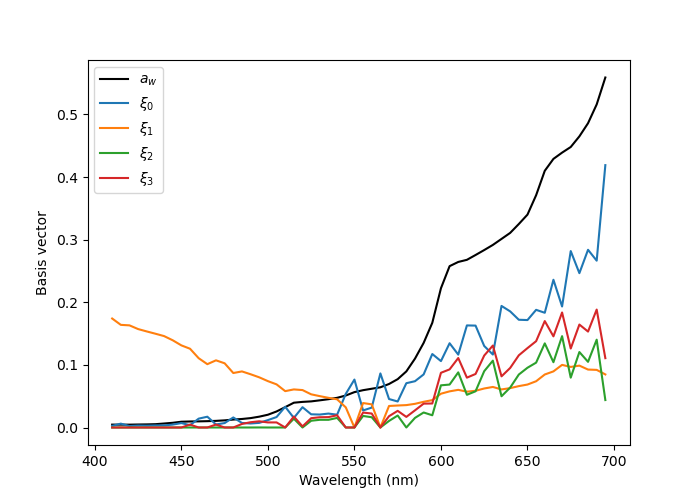

In [73]:
M = CNMF.W.T
#
fig = plt.figure(figsize=(7,5))

pcut = 700.
cut = wave < pcut

plt.clf()
ax = plt.gca()
ax.plot(wave[cut], a_w[cut], 'k', label=r'$a_w$')
for ss in range(M.shape[0]):
    ax.plot(wave[cut],M[ss][cut], label=r'$\xi_'+f'{ss}'+'$')
#
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Basis vector')
ax.legend()
#
plt.show()

## $H_1$

In [50]:
CNMF.H.shape

(4, 3320)

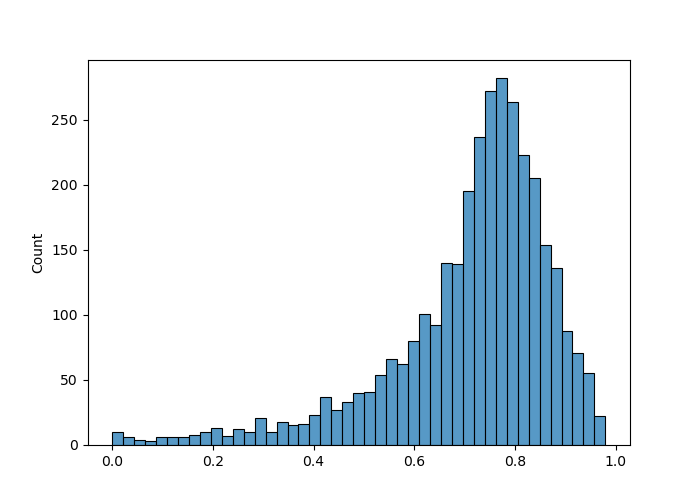

In [51]:
fig = plt.figure(figsize=(7,5))
plt.clf()
ax = plt.gca()

_ = sns.histplot(x=CNMF.H[0], ax=ax)
#
#ax.set_xlabel('Wavelength (nm)')
#ax.set_ylabel('Basis vector')
#ax.legend()
#
plt.show()

----

# What is the "right" value for $H_1$?

In [38]:
coeff = CNMF.H.copy()
coeff[1:,:] = 0.

In [39]:
coeff[0,:20]

array([0.93557562, 0.90058106, 0.6985793 , 0.59940259, 0.67318835,
       0.81724038, 0.84113563, 0.33584786, 0.60729311, 0.86735475,
       0.77210408, 0.72717175, 0.23146897, 0.81042723, 0.93263766,
       0.7401818 , 0.29484935, 0.52950781, 0.54468214, 0.72160012])

In [45]:
recon = np.dot(coeff.T, CNMF.W.T)
recon.shape

(3320, 68)

In [48]:
coeff2 = coeff.copy()
coeff2[0,:] = 1.
#
recon2 = np.dot(coeff2.T, CNMF.W.T)

## Check

In [46]:
spec_w.shape

(3320, 68, 1)

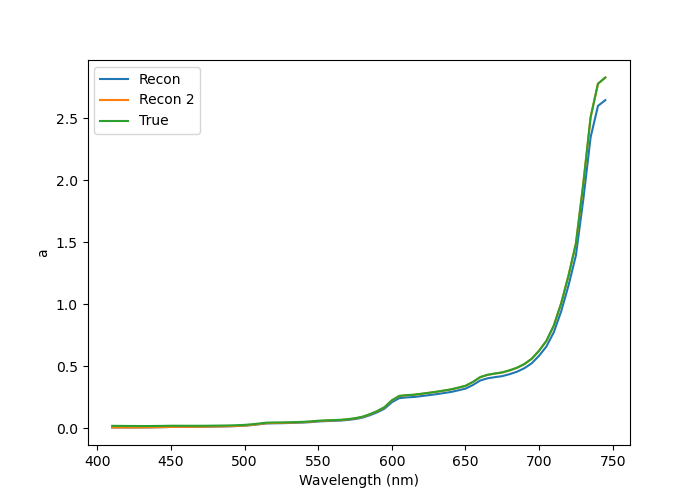

In [49]:
idx = 0

fig = plt.figure(figsize=(7,5))

plt.clf()
ax = plt.gca()

ax.plot(wave, recon[idx], label='Recon')
ax.plot(wave, recon2[idx], label='Recon 2')
ax.plot(wave, spec_w[idx].flatten(), label='True')
#
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('a')
ax.legend()
#
plt.show()